(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

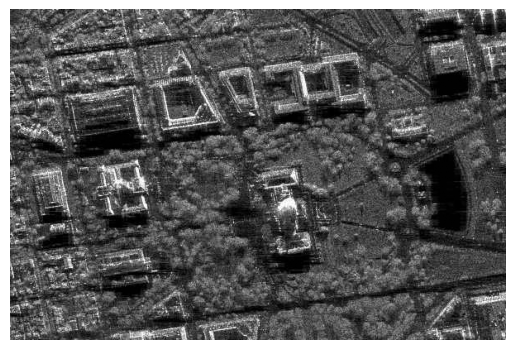

In [1]:
# 1. Сохранение монохромного изображения в виде текстового или бинарного файла.
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("sar_1_gray.jpg", cv2.IMREAD_GRAYSCALE)
np.savetxt("image_text.txt", img, fmt="%d")
img.tofile("image_binary.raw")
plt.imshow(img, cmap="gray")
plt.axis("off")

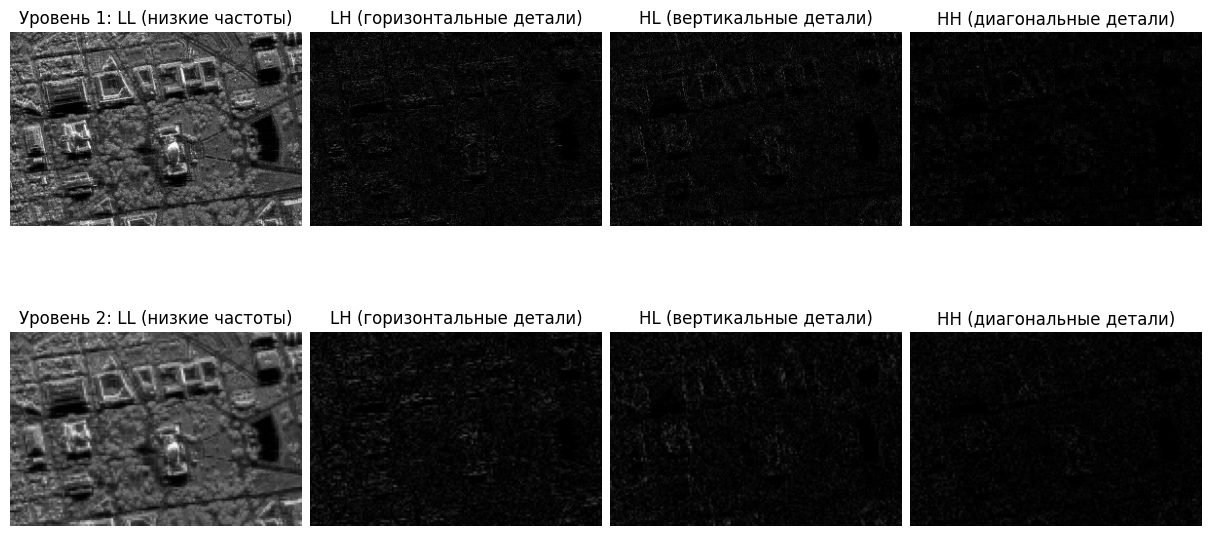

In [5]:
# 2. Реализуйте алгоритм вейвлет-преобразования Хаара для изображения.
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread("sar_1_gray.jpg", cv2.IMREAD_GRAYSCALE)
img = image.tolist()

def haar_1level_basic(matrix):
    h = len(matrix)
    w = len(matrix[0])

    # Горизонтальное разложение (усреднение и разность по строкам)
    rows_low = []
    rows_high = []
    for i in range(h):
        low_row = []
        high_row = []
        for j in range(0, w, 2):
            a = matrix[i][j]
            b = matrix[i][j + 1]
            low = (a + b) / 2
            high = (a - b) / 2
            low_row.append(low)
            high_row.append(high)
        rows_low.append(low_row)
        rows_high.append(high_row)

    # Вертикальное разложение
    LL, LH, HL, HH = [], [], [], []

    for i in range(0, h, 2):
        LL_row, LH_row, HL_row, HH_row = [], [], [], []
        for j in range(len(rows_low[0])):
            a = rows_low[i][j]
            b = rows_low[i + 1][j]
            c = rows_high[i][j]
            d = rows_high[i + 1][j]

            LL_row.append((a + b) / 2)  # низкие по обоим направлениям
            LH_row.append((a - b) / 2)  # низкие по горизонтали, высокие по вертикали
            HL_row.append((c + d) / 2)  # высокие по горизонтали, низкие по вертикали
            HH_row.append((c - d) / 2)  # высокие по обоим направлениям

        LL.append(LL_row)
        LH.append(LH_row)
        HL.append(HL_row)
        HH.append(HH_row)

    return LL, LH, HL, HH


# Многоуровневое преобразование 
levels = 2 
wavelets = [] 
current = img
for _ in range(levels):
    LL, LH, HL, HH = haar_1level_basic(current)
    wavelets.append((LL, LH, HL, HH))
    current = LL 

# Визуализация 
fig, axes = plt.subplots(
    nrows=levels, ncols=4,
    figsize=(12, 3 * levels),
    constrained_layout=True
)

vmin = 0
vmax = np.max(image)

for i, (LL, LH, HL, HH) in enumerate(wavelets):
    level = i + 1
    title_row = f"Уровень {level}"

    # LL 
    axes[i, 0].imshow(LL, cmap='gray', vmin=vmin, vmax=vmax)
    axes[i, 0].set_title(f"{title_row}: LL (низкие частоты)")
    axes[i, 0].axis("off")

    # LH 
    axes[i, 1].imshow(np.abs(LH), cmap='gray', vmin=vmin, vmax=vmax)
    axes[i, 1].set_title("LH (горизонтальные детали)")
    axes[i, 1].axis("off")

    # HL 
    axes[i, 2].imshow(np.abs(HL), cmap='gray', vmin=vmin, vmax=vmax)
    axes[i, 2].set_title("HL (вертикальные детали)")
    axes[i, 2].axis("off")

    # HH 
    axes[i, 3].imshow(np.abs(HH), cmap='gray', vmin=vmin, vmax=vmax)
    axes[i, 3].set_title("HH (диагональные детали)")
    axes[i, 3].axis("off")

plt.show()


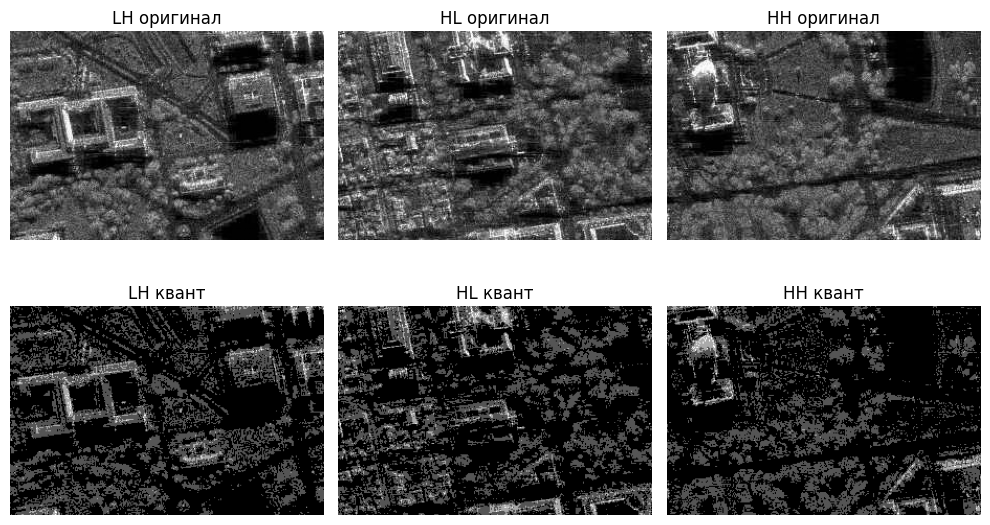

In [10]:
# Задача 3. Квантование высокочастотных компонент (количество квантов = 4).
img = cv2.imread('sar_1_gray.jpg', cv2.IMREAD_GRAYSCALE)

# Разобьём изображение на 4 блока, имитируя LL, LH, HL, HH
h, w = img.shape
half_h, half_w = h // 2, w // 2

LL = img[:half_h, :half_w]
LH = img[:half_h, half_w:]
HL = img[half_h:, :half_w]
HH = img[half_h:, half_w:]

def quantize_component(component, num_levels=4):
    c_min, c_max = component.min(), component.max()
    norm = (component - c_min) / (c_max - c_min)
    quantized = np.floor(norm * (num_levels - 1))
    return quantized.astype(np.uint8)

LH_q = quantize_component(LH)
HL_q = quantize_component(HL)
HH_q = quantize_component(HH)

plt.figure(figsize=(10, 6))

plt.subplot(2, 3, 1)
plt.imshow(LH, cmap='gray')
plt.title('LH оригинал')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(HL, cmap='gray')
plt.title('HL оригинал')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(HH, cmap='gray')
plt.title('HH оригинал')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(LH_q, cmap='gray')
plt.title('LH квант')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(HL_q, cmap='gray')
plt.title('HL квант')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(HH_q, cmap='gray')
plt.title('HH квант')
plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
# Сохраните получившийся массив значений в текстовый или бинарный файл в порядке LL,
# LH, HL, HH вейвлет-преобразования Хафа. Компоненты LH, HL, HH храните в виде пар
# (значение, количество повторений).
def rle_encode(array):
    flat = array.flatten()
    result = []
    count = 1
    for i in range(1, len(flat)):
        if flat[i] == flat[i-1]:
            count += 1
        else:
            result.append((int(flat[i-1]), count))
            count = 1
    result.append((int(flat[-1]), count))
    return result

LH_rle = rle_encode(LH_q)
HL_rle = rle_encode(HL_q)
HH_rle = rle_encode(HH_q)

with open("haar_result.bin", "wb") as f:
    f.write(LL.astype(np.float32).tobytes())
    for comp in [LH_rle, HL_rle, HH_rle]:
        for val, cnt in comp:
            f.write(np.uint8(val).tobytes())
            f.write(np.uint16(cnt).tobytes())

original_size = LH_q.size + HL_q.size + HH_q.size
compressed_size = sum(len(c) for c in [LH_rle, HL_rle, HH_rle])
compression_ratio = original_size / compressed_size
print(f"Степень сжатия = {compression_ratio:.2f}x")

Степень сжатия = 4.75x


In [21]:
# Сравните объем памяти, занимаемый исходным изображением (попиксельное хранение), и
# изображение, полученным после преобразования Хафа и сжатием длин серий.
orig_size = os.path.getsize("image_binary.raw")
compressed_size = os.path.getsize("haar_result.bin")

print(f"Исходный размер: {orig_size} байт")
print(f"После Хаара + квантования + RLE: {compressed_size} байт")
print(f"Коэффициент сжатия: {orig_size / compressed_size}")

Исходный размер: 240000 байт
После Хаара + квантования + RLE: 353724 байт
Коэффициент сжатия: 0.6784950978729178
